## Creating pipelines in AzureML

This notebook will show how to create a very simple pipeline. Lets do some imports and connect to AzureML.

In [5]:
#housekeeping
import os

# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential, AzureCliCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

To use the Machine Learning Workspace and create an ml_client, you need to have azure cli installed and be logged in through `az login`. We will make an ml_client instance from our config.json, for which you can find the values in the azure portal. The config.json file lives at the root of the repo and is found by the sdk when you call the .from_config() method.

In [6]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    print("DefaultAzureCredential not working, Try to run 'az login' or fallback to InteractiveBrowserCredential")
    credential = InteractiveBrowserCredential()
    
ml_client = MLClient.from_config(credential)

Found the config file in: /home/daniel/repos/aml2/config.json


### Environments
Our code is going to run on compute infrastructure in the cloud. For this to go well, we need to define what kind of environment we want our code to run in. We can either do this by using a ready-made `curated environment` from azureml, create your own fully custom docker definition, or define a conda specification that will be used to create an environment in a docker base image. We will use this approach.

First, we write our conda specification for our `helloworld` environment to our `/environments/` folder:

In [7]:
!mkdir ../environments

mkdir: cannot create directory ‘../environments’: File exists


In [8]:
%%writefile ../environments/helloworld.yaml
name: catsanddogsenv
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2

Overwriting ../environments/helloworld.yaml


We now have a very simple conda specification in a yml file. We can use this to define an azureml environment:

In [9]:
from azure.ai.ml.entities import Environment

#give our environment a name
custom_env_name = "helloworldenv"

helloworldenv = Environment(
    name=custom_env_name,
    description="Custom environment for our hello world example",
    tags={"scikit-learn": "0.24.2"}, #you can add tags to your environment
    conda_file= "../environments/helloworld.yaml",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest", #you have to supply a base docker image. This one is from AzureML
    )

Now we have everything ready, but nothing has happened in AzureML yet. The SDK is lazy and we have not even actually authenticated properly. All of this will happen when we make the first call with our ml_client. The most used method we call is `create_or_update`, which is named pretty self-explanatory. Whatever you put in there gets created our updated. Lets make our environment in the cloud.

In [8]:
ml_client.environments.create_or_update(helloworldenv)

Environment({'arm_type': 'environment_version', 'latest_version': None, 'image': 'mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'helloworldenv', 'description': 'Custom environment for our hello world example', 'tags': {'scikit-learn': '0.24.2'}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': False, 'id': '/subscriptions/11f51dee-57cd-4d47-b542-8e244706e163/resourceGroups/sbx-dondorp/providers/Microsoft.MachineLearningServices/workspaces/amlsbxdondorp/environments/helloworldenv/versions/1', 'Resource__source_path': '', 'base_path': '/home/daniel/repos/aml2/notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f10ee6b1330>, 'serialize': <msrest.serialization.Serializer object at 0x7f10ee6b1c00>, 'version': '1', 'conda_file': {'channels': ['conda-forge'], 'dependencies': ['python=3.8', 'numpy=1.21.2', '

Now you can go check in ml studio in the browser that the environment is created and an image build is triggered.
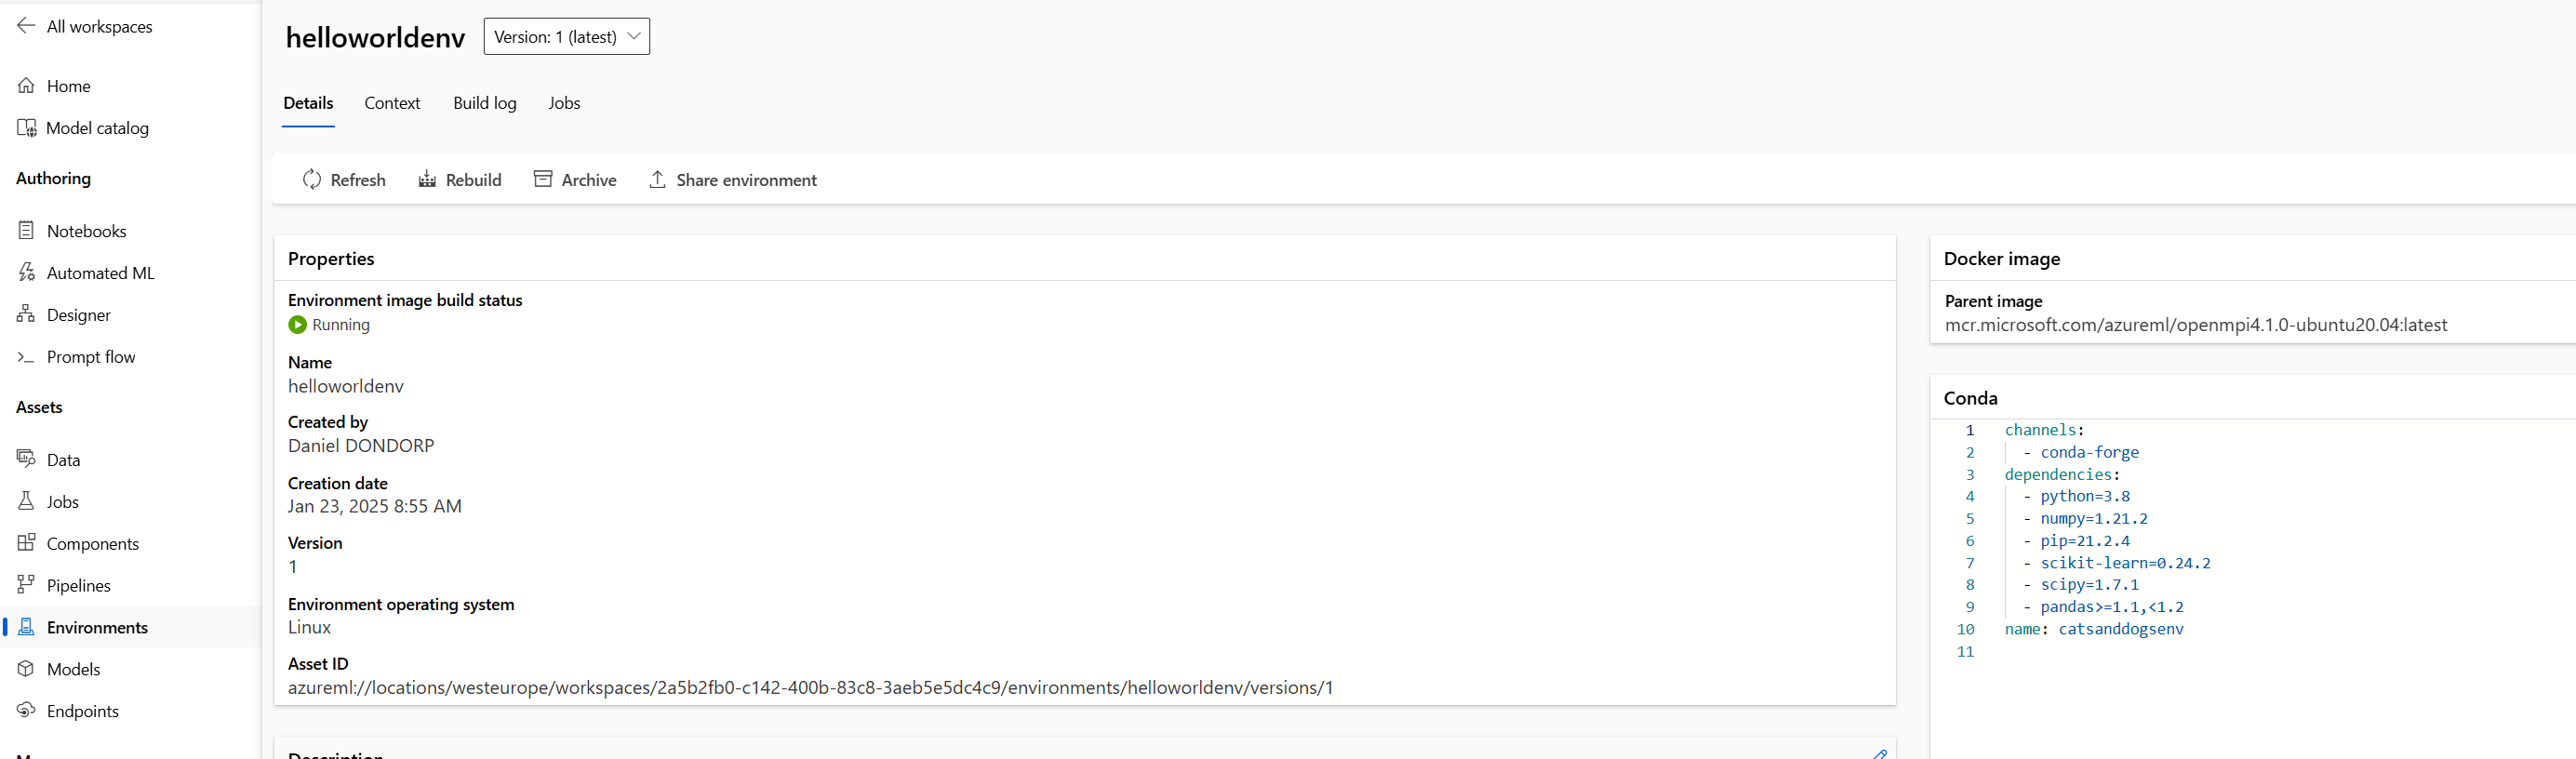

### Create compute
To run actual code to do actual work we will need to create compute resources. 

In [10]:
from azure.ai.ml.entities import AmlCompute

compute_name = "defaultclustersbxdondorp"
helloworld_compute= AmlCompute(name=compute_name, size="STANDARD_DS3_v2")
## We already have this in the workspace, so this is just to show how to create a new one. No need to run it.
#ml_client.compute.create_or_update(ci_basic)

## Create a job
Now we can use our compute and our environment to run jobs! Lets run a very simple one:

In [13]:
from azure.ai.ml import command
#a job that runs a simple hello world command
helloworldjob = command(name="helloworldjob2",
                        compute=compute_name, #supply the compute name we created earlier
                        environment=f"{custom_env_name}:1", #specify the environment we created earlier, and the version
                        command="echo 'Hello World!'") #the command we want to run, this can be a call to a python script, or a bash script or whatever.

In [14]:
helloworldjob = ml_client.jobs.create_or_update(helloworldjob)

This will submit the job to the compute, and you can inspect it in the studio.

In [23]:
helloworldjob.studio_url

'https://ml.azure.com/runs/helloworldjob?wsid=/subscriptions/11f51dee-57cd-4d47-b542-8e244706e163/resourcegroups/sbx-dondorp/workspaces/amlsbxdondorp&tid=8b87af7d-8647-4dc7-8df4-5f69a2011bb5'

You should end up with a completed job that echos "Hello world" in the output log. Fun! You can use this to run code in the cloud and its powerful. You can create good GPU Resources and run all sorts of heavy code. But we want more. We want to be able to give our job inputs, outputs, and splice it together with other jobs. We want _pipelines_.

### Lets make our job a pipeline component
We can create a python script that does the same thing as our hello world, but this time lets give it some parameters we can control, for example, we can make it print our name. We will also make it chose a random number that we can write to a file to demonstrate outputs.

Components live in their own folders, and input arguments are supplied through the argparse library.

In [15]:
#first we make the destination folder where our script will live:

os.makedirs("../components/helloworld", exist_ok=True)

In [16]:
%%writefile ../components/helloworld/helloworld.py
import argparse
import numpy as np
import os

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--name", type=str, default="user")
    parser.add_argument("--output_path", type=str, default="./") #we will pass this in from the pipeline. Counterintuitively, the output is an input argument.
    args = parser.parse_args()
    name = args.name
    print(f"Hello, {name}!")
    random_number = np.random.randint(0, 100)
    print(f"Here's a random number: {random_number}")
    with open(os.path.join(args.output_path, "helloworldfile.txt"), "w") as f:
        f.write(f"Hello {name}, here is a random number: {random_number}")

if __name__ == "__main__":
    main()



Writing ../components/helloworld/helloworld.py


Now we can test our script:

In [17]:
!python ../components/helloworld/helloworld.py --name Daniel

Hello, Daniel!
Here's a random number: 56


In [18]:
!cat ./helloworldfile.txt

Hello Daniel, here is a random number: 56

Ok, that works. Now lets make this run on our cloud compute as a pipeline. Our component has `Inputs`: the name, and `Outputs`, the random number.

In [19]:
from azure.ai.ml import Input, Output
inputs = {"name": Input(type="string")}
outputs = {"output_path": Output(type="uri_folder")}

helloworldcomponent = command(
        name="helloworldcomponent",
        code="../components/helloworld/",
        inputs=inputs,
        outputs=outputs,
        environment=f"{custom_env_name}:1",
        command="""python helloworld.py --name ${{inputs.name}} --output_path ${{outputs.output_path}}"""
        )

We have now defined a pipeline step where we have control of the input, and we can see the output. Lets try to create the pipeline that runs it.


In [20]:
#import dsl
from azure.ai.ml import dsl

In [21]:
@dsl.pipeline(name="helloworldpipeline", description="A simple hello world pipeline", compute=compute_name)
def helloworld_pipeline(name:str):
    helloworldjob = helloworldcomponent(name=name)
    return {"output_path": helloworldjob.outputs.output_path}

In [22]:
helloworld_pipeline_instance = helloworld_pipeline(name="Daniel")
ml_client.jobs.create_or_update(helloworld_pipeline_instance)

pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored


Experiment,Name,Type,Status,Details Page
notebooks,polite_school_ry9n37hlzq,pipeline,NotStarted,Link to Azure Machine Learning studio


Cool, we now have a pipeline with one step that takes a name and spits out a file with a random number in it. What if we want to use this number for something in a second step? We can create another component that takes the `output` from step 1 as its own `input` again! Lets create a multiplier component:

In [23]:
os.makedirs("../components/helloworldmultiplier/", exist_ok=True)

In [24]:
%%writefile ../components/helloworldmultiplier/helloworldmultiplier.py
import argparse
import numpy as np
import os

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_path", type=str, default="./") #we will pass this in from the pipeline.
    parser.add_argument("--output_path", type=str, default="./") #we will pass this in from the pipeline. Counterintuitively, the output is an input argument.
    args = parser.parse_args()
    with open(os.path.join(args.input_path, "helloworldfile.txt"), "r") as f:
        contents = f.read()
    print(f"We have found the following file: \n {contents}")
    #lets slice the integer out of the file:
    number = int(contents.split(":")[-1].strip())
    number = number * 2
    print(f"The number from the previous step, doubled, is: {number}")
    with open(os.path.join(args.output_path, "helloworldmultiplierfile.txt"), "w") as f:
        f.write(f"The number from the previous step, doubled, is: {number}")

if __name__ == "__main__":
    main()

Writing ../components/helloworldmultiplier/helloworldmultiplier.py


In [25]:
# we can now define our component
inputs = {"input_path": Input(type="uri_folder")}
outputs = {"output_path": Output(type="uri_folder")}
helloworldmultipliercomponent = command(
        name="helloworldmultipliercomponent",
        code="../components/helloworldmultiplier/",
        inputs=inputs,
        outputs=outputs,
        environment=f"{custom_env_name}:1",
        command="""python helloworldmultiplier.py --input_path ${{inputs.input_path}} --output_path ${{outputs.output_path}}"""
        )

In [26]:
# we can now define our pipeline
@dsl.pipeline(name="helloworldmultipipeline", description="A slightly less simple hello world pipeline", compute=compute_name)
def helloworldmulti_pipeline(name:str):
    helloworldjob = helloworldcomponent(name=name)
    helloworldmultiplierjob = helloworldmultipliercomponent(input_path=helloworldjob.outputs.output_path)
    return {"output_path": helloworldmultiplierjob.outputs.output_path}

In [27]:
# and run it
helloworldmulti_pipeline_instance = helloworldmulti_pipeline(name="Daniel")
ml_client.jobs.create_or_update(helloworldmulti_pipeline_instance)

pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored
pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored


Experiment,Name,Type,Status,Details Page
notebooks,willing_fork_by3c13skd6,pipeline,NotStarted,Link to Azure Machine Learning studio


## Conclusion
This notebook shows how to create simple pipelines with inputs and outputs. I hope it is clear how flexible and easy it is to throw compute at different tasks. It is possible to define compute for the commands specifically instead of on pipeline level as well, making it possible to reserve heavier more expensive GPU resources for tasks that need it, and preprocessing things with lighter clusters to save money and or free up compute for other tasks. For a more specific and useful example, we`ll continue in the catsanddogs notebook.